In [20]:
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import multivariate_normal
from sklearn.decomposition import PCA
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler

In [21]:
def get_data():
    x = pd.read_csv('dataset_tissue.txt', index_col=None)
    x = x.drop(x.columns[0], axis=1)

    labels = pd.read_csv('clase.txt', skiprows=1, names=["index", "label"])
    labels = labels.drop("index", axis=1)

    y = np.array(labels["label"])
    x = np.array(x.iloc[:, :]).T
    return x, y

In [22]:
x, y = get_data()
n_labels = len(np.unique(y))


In [23]:
# Assuming x is your data and y is your labels
data = x  # Replace with your actual data
labels = y  # Replace with your actual labels

# Apply PCA to reduce dimensionality
pca = PCA(n_components=66)
data_pca = pca.fit_transform(data)


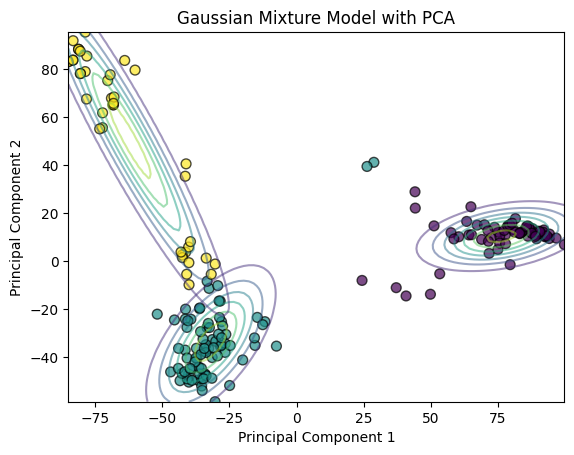

In [10]:
class GMM:
    def __init__(self, num_components=3, num_iterations=100, tol=1e-4):
        self.num_components = num_components
        self.num_iterations = num_iterations
        self.tol = tol
        self.means = None
        self.covariances = None
        self.weights = None

    def fit(self, data):
        n_samples, _ = data.shape
        self.means = [data[i] for i in range(self.num_components)]
        self.covariances = [np.cov(data.T) for _ in range(self.num_components)]
        self.weights = [1.0 / self.num_components for _ in range(self.num_components)]

        for iteration in range(self.num_iterations):
            # E
            responsibilities = self.e_step(data)

            # M
            total_resp = responsibilities.sum(axis=0)

            for c in range(self.num_components):
                self.means[c] = (data.T @ responsibilities[:, c]) / total_resp[c]
                self.covariances[c] = np.dot((responsibilities[:, c] * (data - self.means[c]).T),
                                             (data - self.means[c])) / total_resp[c]
                self.weights[c] = total_resp[c] / n_samples

        return np.argmax(responsibilities, axis=1)

    def e_step(self, data):
        responsibilities = np.zeros((data.shape[0], self.num_components))

        for c in range(self.num_components):
            diff = data - self.means[c]
            cov_inv = np.linalg.pinv(self.covariances[c])
            exponent = -0.5 * np.sum(diff @ cov_inv * diff, axis=1)
            coef = 1 / ((2 * np.pi) ** (data.shape[1] / 2) * np.sqrt(np.linalg.det(self.covariances[c])))
            responsibilities[:, c] = self.weights[c] * coef * np.exp(exponent)

        responsibilities /= responsibilities.sum(axis=1, keepdims=True)

        return responsibilities

# Create an instance of GMM
gmm = GMM(num_components=3)

# Fit the GMM with PCA-transformed data
labels = gmm.fit(data_pca)

# Scatter plot of data points after PCA
plt.scatter(data_pca[:, 0], data_pca[:, 1], c=labels, cmap='viridis', s=50, edgecolors='k', alpha=0.7)

# Plot GMM contours
x_range = np.linspace(np.min(data_pca[:, 0]), np.max(data_pca[:, 0]), 100)
y_range = np.linspace(np.min(data_pca[:, 1]), np.max(data_pca[:, 1]), 100)
x, y = np.meshgrid(x_range, y_range)
pos = np.dstack((x, y))

for c in range(gmm.num_components):
    plt.contour(x, y, multivariate_normal.pdf(pos, gmm.means[c], gmm.covariances[c]), alpha=0.5)

plt.title('Gaussian Mixture Model with PCA')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


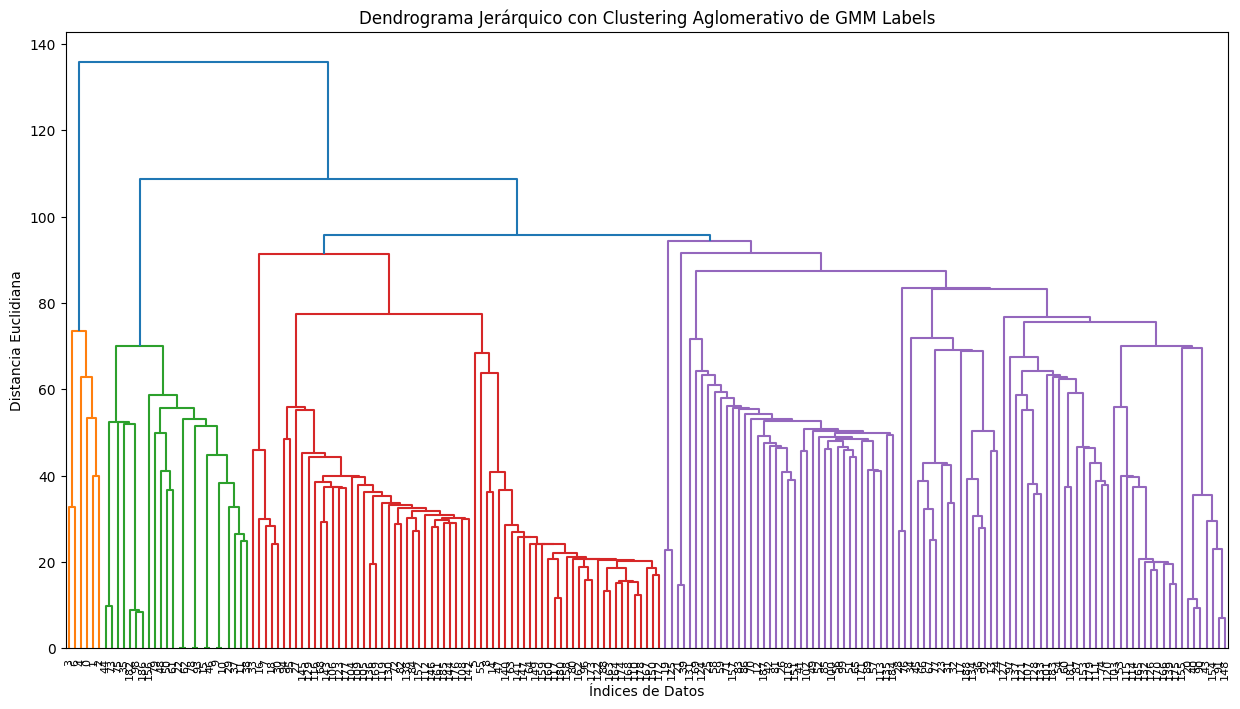

In [24]:
from sklearn.cluster import AgglomerativeClustering
import numpy as np
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage


num_clusters = len(np.unique(labels))
agglomerative_clustering = AgglomerativeClustering(n_clusters=None, affinity='euclidean', linkage='ward',
                                                    distance_threshold=0, compute_full_tree=True)

agglomerative_labels = agglomerative_clustering.fit_predict(data_pca)

Z = linkage(data_pca[agglomerative_labels.argsort()])

plt.figure(figsize=(15, 8))
dendrogram(Z, leaf_rotation=90., leaf_font_size=8., labels=agglomerative_labels[agglomerative_labels.argsort()])
plt.title('Dendrograma Jerárquico con Clustering Aglomerativo de GMM Labels')
plt.xlabel('Índices de Datos')
plt.ylabel('Distancia Euclidiana')
plt.show()


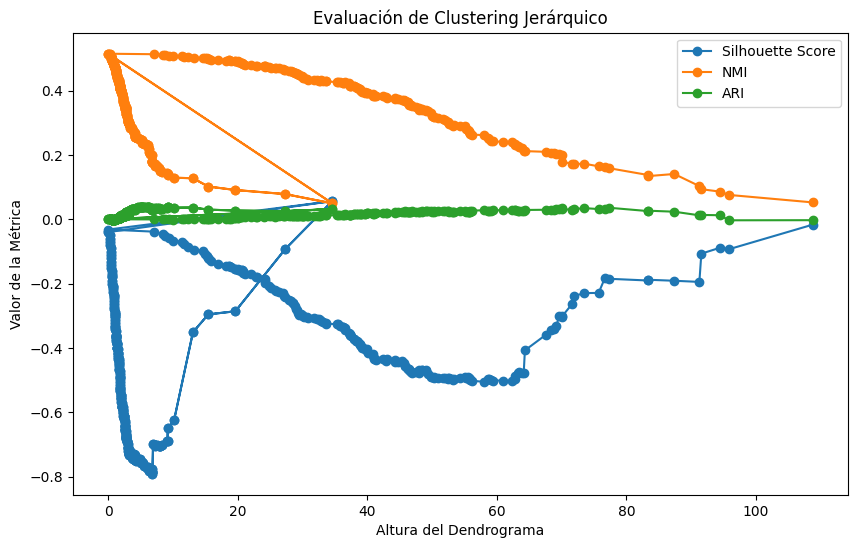

In [25]:
# Cambia el valor de min_clusters según tus necesidades
min_clusters = 2

# Itera sobre diferentes alturas del dendrograma
for height in np.unique(Z[:, 2]):
    # Asigna puntos a clústeres según la altura del dendrograma
    cluster_labels = fcluster(Z, height, criterion='distance')

    # Verifica si hay al menos min_clusters clústeres
    unique_clusters = len(np.unique(cluster_labels))
    if unique_clusters >= min_clusters:
        # Calcula Silhouette Score, NMI y ARI solo si hay al menos min_clusters clústeres
        silhouette = silhouette_score(data_pca, cluster_labels)
        nmi = normalized_mutual_info_score(y_true, cluster_labels)
        ari = adjusted_rand_score(y_true, cluster_labels)

        # Almacena las métricas y la altura actual
        silhouette_scores.append(silhouette)
        nmi_scores.append(nmi)
        ari_scores.append(ari)
        heights.append(height)

# Grafica las métricas en función de la altura del dendrograma
plt.figure(figsize=(10, 6))
plt.plot(heights, silhouette_scores, label='Silhouette Score', marker='o')
plt.plot(heights, nmi_scores, label='NMI', marker='o')
plt.plot(heights, ari_scores, label='ARI', marker='o')
plt.xlabel('Altura del Dendrograma')
plt.ylabel('Valor de la Métrica')
plt.legend()
plt.title('Evaluación de Clustering Jerárquico')
plt.show()
